Three simple drift diffusion models to describe the reaction time in a task with uncertainty
By Clara Kuper, October 2020

Hypothesis: The time it takes to select a manual movement plan is influenced by the certainty of the sensory evidence and dynamically updated, as the evidence changes.
To support this hypothesis, I will fit 3 models to data in a rapid go/no-go paradigm.

The first model assumes that the drift rate is fixed for each trial and does not depend on the certainty of sensory evidence.

The second model assumes that the drift rate is fixed per trial, depending on the evidence in the first moment a decision threshold is crossed.

The third model assumes that the drift rate dynamically changes within the trial, whenever new evidence is presented. 

In [1]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# library for bayesian optimization
from skopt import gp_minimize, dump, load
import skopt.plots

In [2]:
# Define an integrator function that can integrate over functions with a deterministic and a stochastic part:

def euler_maruyama(pfun, ffun, gfun, x0, t, dt, **kwargs):
    """
    integrates functions with a stochastic part.
    
    input parameters:
    pfun: the function that generates parameters for ffun
    ffun: function
        this is a function that contains the deterministic part of the system of equations
    gfun: function
        this is a function that contains the stochastic part of the system of equations
    x0: the initial starting values of the variable being integrated
    t: np.array
        the time array in which the function integrates
    kwargs: dict
        a dicitonary of all arguements beeing passed to pfun and gfun
        
    
    returns: 
    s: np.array
        contains the values of x0 at each timepoint with step size dt.
    """
    # initialize values that will be stacked later in the function
    X_t = x0
    s = X_t
    threshold_go = kwargs['threshold_go']
    rt = None
    resp = None
    
    # in case the model integrates over more than one value, we might have different noise levels per condition
    if type(X_t) == int:
        noiseLen = 1
    else:
        noiseLen = len(X_t)
    
    # get the paramters for the functions below
    params = pfun(t, **kwargs)
    
    for time in t[1:]:
        Wt = np.random.normal(0,1,noiseLen)
        #perform the update step
        drift = ffun(time,**params)
        X_t1 = X_t + drift*dt + gfun(**kwargs)*np.sqrt(dt)*Wt
        s = np.vstack([s, X_t1])
        # check if threshold was crossed
        if abs(X_t1) >= threshold_go and (rt is None):
            #print(X_t1)
            
            rt = time
            if X_t1>0:
                resp = 'go'
            else:
                resp = 'nogo'
        
        X_t = X_t1
    
    if rt is None:
        # if the threshold was never crossed, just compute the remaining duration
        if drift > 0:
            rt = threshold_go/drift
        else:
            # divide by a small number is a zero division occurs
            rt = 1
        if X_t1 > 0:
            resp = 'go' 
        else:
            resp = 'nogo'
        
    return s, rt, resp

In [3]:
# noise model
def stoch_var(**args):
    """
    returns the variance of the noise, as given in the keyword arguments
    """
    
    return args['sigma']

Below, I define the models. Important to node, these models take keyword arguments that are generated by another function, specific to the model. Those are defined in the next section.

In [4]:
# model 1

def model1(t,**args):
    """
    A drift diffusion model with a fixed drift rate, returns only the drift rate, 
    the stochastic part is taken care of by the integrator function above 
    """
    
    
    return args['drift_rate']*args['chosen_resp']
    

In [5]:
# model 2
def model2(t,**args):
    """
    a model that returns drift rate 0 when evidence at the given time point is below threshold
    and return a fixed drift rate when evidence is above the threshold. The drift rate is modulated by 
    a generic drift rate weight
    it takes an argument for the time when the drift starts and the value at which the drift starts
    """
    
    evidence = args['evidence_drift']
    drift_weight = args['drift_weight']

    
    if t < args['time_drift']:
        return 0
    
    else:
        return drift_weight * evidence
    

In [6]:
# model 3
def model3(t,**args):
    
    """
    a model that returns the current evidence modulated by 
    a generic drift rate weight as drift rate
    the evidence vector needs the same size and time scale as the time vector
    """
    trial = args['trial']
    
    try:
        last_update = np.argmax(trial['time'][trial['time']<=t])
        evidence = trial['p_in'].iloc[last_update]
        evidence_norm = evidence - 0.5
        
    except:
        evidence_norm = 0
    
    drift_weight = args['drift_weight']
    
    return drift_weight * evidence_norm

Here I define the paramters the models take in. This is specific for each model.

In [7]:
def get_params_model1(time, **args):
    
    """
    this returns the drift rate value set in the arguments
    """
    
    first_evidence_val = args['trial']['p_in'][0]
    if first_evidence_val <= 0.5:
        chosen_resp = -1
    else:
        chosen_resp = 1
    
    params = {
        'drift_rate': args['drift_rate'],
        'chosen_resp': chosen_resp
    }
    
    return params

In [8]:
# translate the evidence to a drift rate in model 2
def get_params_model2(time, **args):
    
    """
    input: evidence - np array with "time" and "p_in"
    
    returns 
    the time point when the threshold is reached (drift start)
    and the value for which the threshold is reached (evidence)
    
    and also returns weight of evidence
    """
    
    # normalize p_in
    evidence_norm = args['trial']['p_in']-0.5
    
    # the try-except stucture takes care of cases in which the threshold is never crossed.
    try:
        # find the first value where the threshold is crossed
        idx = np.min(np.where(abs(evidence_norm)>args['threshold_drift'])[0])
        # time point of go for drift
        time_drift = args['trial']['time'].iloc[idx]
        # value of go for drift
        evidence_drift = evidence_norm[idx]
        
        # save paramters
        params = {

            'time_drift': time_drift,
            'evidence_drift': evidence_drift,
            'drift_weight': args['drift_weight']
        }
        
    except ValueError:
        
        # for now the parameters when the threshold is never crossed are set to zero, 
        # but we could also have a more elaborate decision here
        params = {

            'time_drift': 0,
            'evidence_drift': 0,
            'drift_weight': args['drift_weight']
        }
    
    return params
    

In [9]:
def get_params_model3(time, **args):
    
    """
    this function returns a vector in the length of the time vector with the corresponding evidence value at each ms.
    also, it returns the drift weight
    
    both values are stored in a dicitonary that is fed into the model.
    """
    
    params = {
        'trial': args['trial'],
        'drift_weight': args['drift_weight']
    }
    
    return params

#### All functions are defined above. Here, we simulate the drift process.

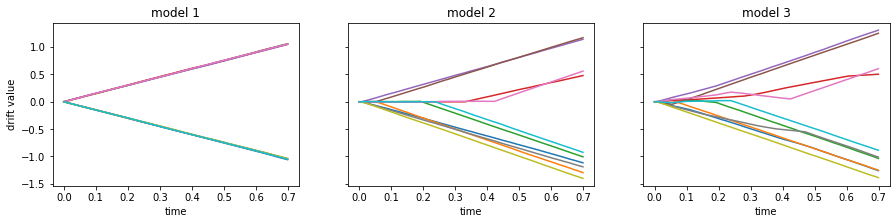

In [15]:
# # Simulate Drift
# # load data from simulated experiment
# df = pd.read_csv('sim_full.csv')

# # define fixed params
# X0 = 0 # start value of the drift process
# dt = 0.001 # integration time step
# dur = max(df['time']) # time for which we run the simulation
# T = np.arange(0, dur, dt) # time vector for the simulation

# # define variable params:
# sigma = 0.01 # variance
# drift_weight = 4.0
# threshold_drift = 0.3
# drift_rate = 1.5
# threshold_go = 0.5

# # initialize plot
# fig, ax = plt.subplots(1,3, figsize = (15,3), sharex = True, sharey = True)
# trial_n = len(np.unique(df['trial']))

# # set up data frames
# m1_drift = pd.DataFrame(np.zeros((trial_n,len(T))))
# m2_drift = pd.DataFrame(np.zeros((trial_n,len(T))))
# m3_drift = pd.DataFrame(np.zeros((trial_n,len(T))))

# m1_rt = pd.Series(np.zeros(trial_n))
# m2_rt = pd.Series(np.zeros(trial_n))
# m3_rt = pd.Series(np.zeros(trial_n))

# m1_resp = pd.Series(np.zeros(trial_n))
# m2_resp = pd.Series(np.zeros(trial_n))
# m3_resp = pd.Series(np.zeros(trial_n))

# ## Start simulation

# for idx, trial in enumerate(np.unique(df['trial'])):
    
#     # get data from current trial only
#     trial_data = df[df['trial'] == trial] 
#     trial_data.reset_index(drop=True, inplace = True)

#     # set parameters for drift
#     trial_params = {
#     'sigma': sigma,
#     'trial': trial_data,
#     'drift_weight': drift_weight,
#     'threshold_drift': threshold_drift,
#     'drift_rate': drift_rate,
#     'threshold_go': threshold_go    
#     }
    
#     # run drift diffusion    
#     simulation_m1,rt_m1,res_m1 = euler_maruyama(get_params_model1, model1, stoch_var, X0, T, dt, **trial_params)
#     simulation_m2,rt_m2,res_m2 = euler_maruyama(get_params_model2, model2, stoch_var, X0, T, dt, **trial_params)
#     simulation_m3,rt_m3,res_m3 = euler_maruyama(get_params_model3, model3, stoch_var, X0, T, dt, **trial_params)
    
#     # write drift result to table
#     m1_drift.iloc[idx,:] = simulation_m1.T[0]
#     m1_rt.iloc[idx] = rt_m1
#     m1_resp.iloc[idx] = res_m1

#     m2_drift.iloc[idx,:] = simulation_m2.T[0]
#     m2_rt.iloc[idx] = rt_m2
#     m2_resp.iloc[idx] = res_m2

#     m3_drift.iloc[idx,:] = simulation_m3.T[0]
#     m3_rt.iloc[idx] = rt_m3
#     m3_resp.iloc[idx] = res_m3

        
#     # plot if needed    
#     if trial % 111 == 0:
#         ax[0].plot(T, simulation_m1)
#         ax[0].set_title('model 1')
#         ax[0].set_xlabel('time')
#         ax[0].set_ylabel('drift value')
#         ax[1].plot(T, simulation_m2)
#         ax[1].set_title('model 2')
#         ax[1].set_xlabel('time')
#         ax[2].plot(T, simulation_m3)
#         ax[2].set_title('model 3')
#         ax[2].set_xlabel('time')
        
        
        

In [31]:
# m1_drift.to_csv('m1_drift.csv', sep=',')
# m2_drift.to_csv('m2_drift.csv', sep=',')
# m3_drift.to_csv('m3_drift.csv', sep=',')

# m1_rt.to_csv('m1_rt.csv', sep =',') 
# m2_rt.to_csv('m1_rt.csv', sep =',') 
# m3_rt.to_csv('m1_rt.csv', sep =',') 

# m1_resp.to_csv('resp_rt.csv', sep =',') 
# m2_resp.to_csv('resp_rt.csv', sep =',') 
# m3_resp.to_csv('resp_rt.csv', sep =',') 

In [12]:
# instead of simulating new data, we load the data we've simulated last time
m1_drift = pd.read_csv('m1_drift.csv')
m2_drift = pd.read_csv('m2_drift.csv')
m3_drift = pd.read_csv('m3_drift.csv')

m1_rt = pd.read_csv('m1_rt.csv')
m2_rt = pd.read_csv('m1_rt.csv')
m3_rt = pd.read_csv('m1_rt.csv')

m1_resp = pd.read_csv('m1_resp.csv')
m2_resp = pd.read_csv('m1_resp.csv')
m3_resp = pd.read_csv('m1_resp.csv')



0.011624909500197365


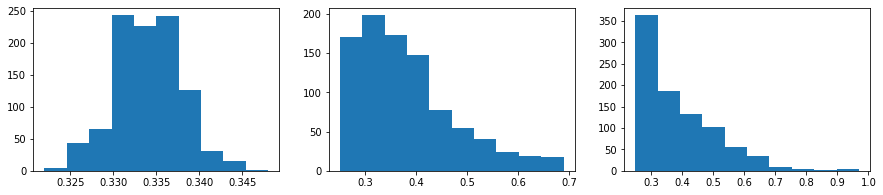

In [30]:
hist_plot, hist_axs = plt.subplots(1,3, figsize = (15,3), sharex=False, sharey=False)

hist_axs[0].hist(m1_rt);
hist_axs[1].hist(m2_rt[m2_rt<1]);
hist_axs[2].hist(m3_rt[m3_rt<1]);

print(mse(m2_rt[m3_rt<1],m3_rt[m3_rt<1]))

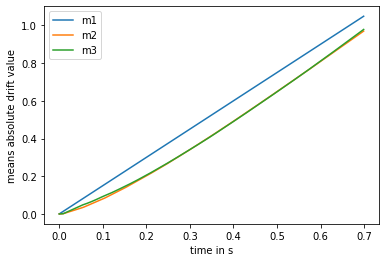

In [19]:
# the mean drift of each model in each tp
m1_mean = np.mean(abs(m1_drift),axis = 0)
m2_mean = np.mean(abs(m2_drift),axis = 0)
m3_mean = np.mean(abs(m3_drift),axis = 0)

fig2,ax2 = plt.subplots(1,1);

ax2.plot(T,m1_mean, label = 'm1')
ax2.plot(T,m2_mean, label = 'm2')
ax2.plot(T,m3_mean, label = 'm3')
ax2.legend()
ax2.set_xlabel('time in s')
ax2.set_ylabel('means absolute drift value');

A reminder, these are the values we set to generate the decisions above:
    

    sigma = 0.01 
    drift_weight = 4.0
    threshold_drift = 0.3
    drift_rate = 1.5
    threshold_go = 0.5
        
Let's try if we can fit these paramters :)

In [20]:
# mean squared errors function
def mse(modelled_data, measured_data):
    """
    returns the mean squared error between two data sets. Important: both datasets need to have the same length
    """
    mse = np.mean((modelled_data-measured_data)**2)
    return mse

# build an objective function

def objective_m1(params, X0 = 0, dt = dt, threshold_go = threshold_go):
    
    """
    The objective we are trying to minimize later - takes the paramters we are using to fit the function
    fits the function as refined and
    returns a metric to evaluate the function fit to the data (mse in this case)
    this objective function is fed into the optimizer function.
    
    Some variables need to be defined before executing this function:
    data_go = the experimental setup and information for every trial (with or without no_gos).
    drift_slice = the indices to trials with "go" responses (= trial numbers)
    m1_drift_go = the measured data - same length as data_slice
    """
    
    # unpack params
    drift_rate = params[0]
    sigma = params[1]
    
    # constant params
    #X0 = 0 # start value of the drift process
    #dt = 0.001 # integration time step
    data = data_go.reset_index(drop=True) # data_go needs to be defined in the workspace before executing this function
    x = m1_drift_go.reset_index(drop=True) #m1_drift_go needs to be defined before executing

    dur = max(data['time']) # time for which we run the simulation
    T = np.arange(0, dur, dt) # time vector for the simulation
    
    # init data frames
    sim_drift = pd.DataFrame(np.zeros((len(drift_slice),len(T))))
    sim_rt = pd.Series(np.zeros(len(drift_slice)))
    sim_resp = pd.Series(np.zeros(len(drift_slice)))
         
    # get reaction for every trial
    for idx, trial in enumerate(drift_slice): 
        # find the experimental setup for the given trial
        trial_data = data[data['trial'] == trial] 
        trial_data.reset_index(drop=True, inplace = True)

        # parameters for drift
        trial_params = {
        'sigma': sigma,
        'drift_rate': drift_rate,
        'trial': trial_data,
        'threshold_go': threshold_go 
        }
        
        model1_drift, rt, resp = euler_maruyama(get_params_model1, model1, stoch_var, X0, T, dt, **trial_params)
#         if resp != "go":
#             # penalize wrong no_go decisions of cases when the decision boundary was not reached
#             rt = 9999
        # write out information in data frame
        sim_drift.iloc[idx,0:len(model1_drift)] = model1_drift.T[0]
        sim_rt.iloc[idx] = rt
        sim_resp.iloc[idx] = resp
                                             
    try:
        #compute mse
        output = mse(sim_rt, x)
        
    except Exception as e:
        # if something goes wrong, let us know a few things:
        print(sim_rt)
        print(x)
        print('the drift rate was: {}'.format(drift_rate))
        print('sigma was: {}'.format(sigma))
        
        raise e
    return output

In [21]:
# get modelled reaction times, only "go"
# this is to define the variables needed to feed our objective function

drift_slice = np.where(m1_resp == "go")[0]
m1_drift_go = m1_rt[drift_slice]
data_go = df

In [22]:
# define the parameter space where we want to look
space = [(0.0,2.0),#drift rate
         (0.0,0.5)]# sigma

# run the optimizer
r = gp_minimize(objective_m1,space,n_calls=20,random_state=1);   

[1.5615955183290886, 0.0]
0.00018056415478615116


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CB2D8C2148>,
      dtype=object)

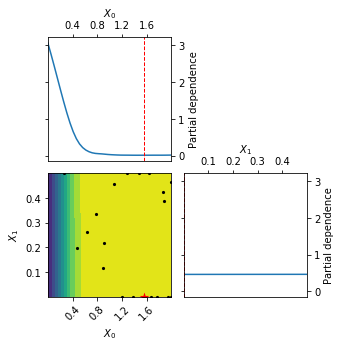

In [23]:
print(r.x)
print(r.fun)
skopt.plots.plot_objective(r)

In [24]:
# build an objective function

def objective_m2(params, X0 = 0, dt = dt, threshold_go = threshold_go):
    
    """
    The objective we are trying to minimize later - takes the paramters we are using to fit the function
    fits the function as refined and
    returns a metric to evaluate the function fit to the data (mse in this case)
    this objective function is fed into the optimizer function.
    
    Some variables need to be defined before executing this function:
    data_go = the experimental setup and information for every trial (with or without no_gos).
    drift_slice = the indices to trials with "go" responses (= trial numbers)
    m2_drift_go = the measured data - same length as data_slice
    """
    
    # unpack params
    drift_weight = params[0]
    threshold_drift = params[1]
    sigma = params[2]
    
    # constant params
    data = data_go.reset_index(drop=True) # data_go needs to be defined in the workspace before executing this function
    #print(data)
    x = m2_drift_go.reset_index(drop=True) #m1_drift_go needs to be defined before executing

    dur = max(data['time']) # time for which we run the simulation
    T = np.arange(0, dur, dt) # time vector for the simulation
    
    # init data frames
    sim_drift = pd.DataFrame(np.zeros((len(drift_slice),len(T))))
    sim_rt  = pd.Series(np.zeros(len(drift_slice)))
    sim_resp = pd.Series(np.zeros(len(drift_slice)))
     
    # get reaction for every trial
    for idx, trial in enumerate(drift_slice): 
        # find the experimental setup for the given trial
        trial_data = data[data['trial'] == trial] 
        trial_data.reset_index(drop=True, inplace = True)

        # parameters for drift
        trial_params = {
        'sigma': sigma,
        'drift_weight': drift_weight,
        'threshold_drift': threshold_drift,
        'trial': trial_data,
        'threshold_go': threshold_go    
        }
        
        model2_drift, rt, resp = euler_maruyama(get_params_model2, model2, stoch_var, X0, T, dt, **trial_params)
        #if resp != "go":
        #    # penalize wrong no_go decisions of cases when the decision boundary was not reached
        #    rt = 9999
        # write out information in data frame
        sim_drift.iloc[idx,:] = model2_drift.T[0]
        sim_rt.iloc[idx] = rt
        sim_resp.iloc[idx] = resp
                                             
    try:
        #compute mse
        output = mse(sim_rt, x)
        
    except Exception as e:
        # if something goes wrong, let us know a few things:
        print(sim_rt)
        print(x)
        print('the drift rate was: {}'.format(drift_rate))
        print('sigma was: {}'.format(sigma))
        
        raise e
    return output

In [25]:
drift_slice = np.where(m2_resp == "go")[0]
m2_drift_go = m2_rt[drift_slice]

# define the parameter space where we want to look
space2 = [(1.0,5.0),#drift weight
          (0, 0.5), #threshold drift
         (0.0,1.0)]# sigma

# run the optimizer
r2 = gp_minimize(objective_m2,space2,n_calls=20,random_state=1); 

[4.655848098316932, 0.22860240399349419, 0.43069856718470856]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CB2DEB96C8>,
      dtype=object)

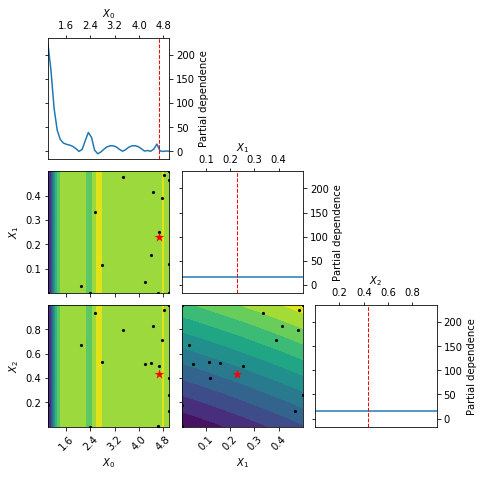

In [26]:
print(r2.x)
skopt.plots.plot_objective(r2)

In [27]:
# build an objective function

def objective_m3(params,X0 = 0, dt = dt, threshold_go = threshold_go):
    
    """
    The objective we are trying to minimize later - takes the paramters we are using to fit the function
    fits the function as refined and
    returns a metric to evaluate the function fit to the data (mse in this case)
    this objective function is fed into the optimizer function.
    
    Some variables need to be defined before executing this function:
    data_go = the experimental setup and information for every trial (with or without no_gos).
    drift_slice = the indices to trials with "go" responses (= trial numbers)
    m3_drift_go = the measured data - same length as data_slice
    """
    
    # unpack params
    drift_weight = params[0]
    sigma = params[1]
    
    # constant params
    #X0 = 0 # start value of the drift process
    #dt = 0.001 # integration time step
    data = data_go.reset_index(drop=True) # data_go needs to be defined in the workspace before executing this function
    #print(data)
    x = m3_drift_go.reset_index(drop=True) #m1_drift_go needs to be defined before executing

    dur = max(data['time']) # time for which we run the simulation
    T = np.arange(0, dur, dt) # time vector for the simulation
    
    # init data frames
    sim_drift = pd.DataFrame(np.zeros((len(drift_slice),len(T))))
    sim_rt  = pd.Series(np.zeros(len(drift_slice)))
    sim_resp = pd.Series(np.zeros(len(drift_slice)))
     
    # get reaction for every trial
    for idx, trial in enumerate(drift_slice): 
        # find the experimental setup for the given trial
        trial_data = data[data['trial'] == trial] 
        trial_data.reset_index(drop=True, inplace = True)

        # parameters for drift
        trial_params = {
        'sigma': sigma,
        'drift_weight': drift_weight,
        'trial': trial_data,
        'threshold_go': threshold_go   
        }
        
        model3_drift, rt, resp = euler_maruyama(get_params_model3, model3, stoch_var, X0, T, dt, **trial_params)
        #if resp != "go":
            # penalize wrong no_go decisions of cases when the decision boundary was not reached
        #    rt = 9999
        # write out information in data frame
        sim_drift.iloc[idx,0:len(model3_drift)] = model3_drift.T[0]
        sim_rt[idx] = rt
        sim_resp[idx] = resp
                                             
    try:
        #compute mse
        output = mse(sim_rt, x)
        
    except Exception as e:
        # if something goes wrong, let us know a few things:
        print(sim_rt)
        print(x)
        print('the drift rate was: {}'.format(drift_rate))
        print('sigma was: {}'.format(sigma))
        
        raise e
    return output

In [28]:
drift_slice = np.where(m3_resp == "go")[0]
m3_drift_go = m3_rt[drift_slice]

# define the parameter space where we want to look
space3 = [(1.0,5.0),#drift weight
         (0.0,1.0)]# sigma

# run the optimizer
r3 = gp_minimize(objective_m3,space3,n_calls=20,random_state=1); 

[3.8638820638734575, 0.2768530088059414]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CB2D74F0C8>,
      dtype=object)

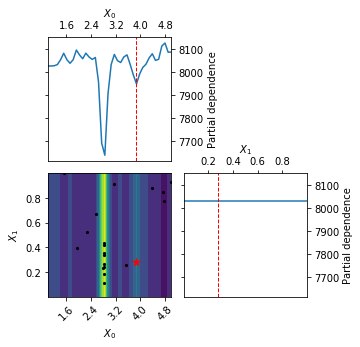

In [29]:
print(r3.x)
skopt.plots.plot_objective(r3)

In [ ]:
dump(r, 'model1optim.pkl')
dump(r2, 'model2optim.pkl')